<a href="https://colab.research.google.com/github/geo4andre/Hyperspectral-Images-processing/blob/main/TA_2_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Text Analytics<br>
## 2st Assignment

Andreadis Georgios | f3352101

Gatos Rafail | f3352103

Koumentakos Agis | f3352108

Moscholios Filippos | f3352116

Stavrou Andreas | f3352120

<br>


### Exercise Requires

Develop a **sentiment classifier** for a kind of texts of your choice (e.g., tweets, product or
**movie reviews**). Use an existing sentiment analysis dataset with at least **two classes** (e.g.,
**positive/negative** or positive/negative/neutral).
The classes should be **mutually exclusive**, i.e.,
this is a single-label multi-class classification problem. You may use Boolean, TF, or **TF-IDF**
features corresponding to words or n-grams, to which you can also add other features (e.g.,
lexicon features). You may apply any feature selection (or **dimensionality reduction**) method
you consider appropriate. You may also want to try using centroids of pre-trained word
embeddings. You can write your own code to produce feature vectors, perform feature
selection (or dimensionality reduction) and train the classifier (e.g., using SGD, in the case of
logistic regression), or you can use existing implementa4
tions and software libraries. You should experiment with **at least logistic regression** (or multinomial logistic regression, if you
have more than two classes) and optionally (if you are keen and have free time) additional
learning algorithms (e.g., **Naive Bayes, k-NN**). Assume that each text is classified in the class
the classifier considers most probable. Make sure that you **use separate training, development, and test subsets** . **Tune the feature set and hyper-parameters** (e.g., regularization weight λ in
logistic regression) **on the development** subset. Include experimental results of a **baseline majority classifier**, i.e., a classifier that always assigns the most frequent class of the training data. Include in your report:

*  Precision, recall, F1, precision-recall AUC scores, for each class and classifier, separately for the training, development, and test subsets. Use three separate tables for the training, development, and test results. In each table, use a separate row for each classifier (or baseline), and show the precision, recall, F1, PR-AUC scores of the classes in columns (four columns per class).


*  Macro-averaged precision, recall, F1, precision-recall AUC scores (all computed by averaging the corresponding scores of the previous bullet over the classes), for each classifier, separately for the training, development, and test subsets. Show these results by adding four more columns to the tables of the previous bullet.


*  For each classifier, learning curves (slides 59, 62) showing macro-averaged F1 computed on (i) the training data the classifier has encountered, (ii) the entire development subset, (iii) the entire test subset. Show a separate diagram for each classifier, with three curves in each diagram.


*  A short description of the methods and datasets you used, including statistics about the datasets (e.g., average document length, number of training/dev/test documents, vocabulary size) and a description of the preprocessing steps that you performed.

## Import the libraries and the dataset

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import re
import joblib

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import time
nltk.download('wordnet')
nltk.download('stopwords')
lemmatizer = WordNetLemmatizer()

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, ShuffleSplit, StratifiedKFold, PredefinedSplit
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, f1_score, precision_recall_curve, roc_curve, auc, precision_recall_fscore_support
from sklearn import svm
from sklearn.svm import SVC as SVM
from sklearn.base import BaseEstimator, clone

from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve
from sklearn.metrics import roc_auc_score

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#!pip install -U -q PyDrive
  
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
  
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
  
# URL and way to get the id part of the file
link = "https://drive.google.com/file/d/1DAOW9YMpNzE6o0mS0immNE-fJxYgdDM-/view?usp=sharing"
id = link.split("/")[-2]
  
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('imdb.csv')  
  
df = pd.read_csv('imdb.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Give **access to the drive** files<br>
*in order to be able to load our pretrained models*



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


***

## Data Preprocessing

**Check for nan values in our dataset**

In [ ]:
df.review.isna().sum()

0

In [ ]:
df.sentiment.isna().sum()

0

**Check the balance of classes** in the raw data

In [ ]:
df.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

Change sentiment from Positive / Negative to **1** / **0**

In [ ]:
# Change sentiment from Positive/Negative to 1/0
df.sentiment = df.sentiment.apply(lambda x: 1 if x=='positive' else 0)

In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


Defining **"preprocess"** function that:
*   converts to lowercase
*   removes underscores
*   removes line breaks 
*   removes numbers
*   removes all single characters
*   substitutes multiple spaces with one space
*   lemmatizing the words


In [ ]:
def preprocess(review):
    # Convert to Lower Case
    review = review.lower()
    
    # Remove underscores 
    review = re.sub(r'[-_]', ' ', review)

    # Remove all possible line breaks 
    review = re.sub(r'<br\s?\/>|<br>', ' ', review)
    
    # Remove numbers
    review = re.sub(r'[0-9]', ' ', review)
    
    # Remove all single characters
    review = re.sub(r'\s+[a-zA-Z]\s+', ' ', review)

    # Substituting multiple spaces with single space
    review = re.sub(r'\s+', ' ', review, flags=re.I)

    # Lemmatization
    review = review.split()

    review = [lemmatizer.lemmatize(word) for word in review]
    review = ' '.join(review)
    return review

In [ ]:
# apply the above function to the review column of our dataset
df.review = df.review.apply(lambda x : preprocess(x))

**Split the dataset in train - dev - test set**

The splitting is 70-15-15 

In [ ]:
# Split the data into train, development and test set
train_total, test = train_test_split(df, test_size=0.15, stratify = df.sentiment, random_state=1994)

# reset the index of the train total in order for us to be easier to use the predefined split later on
train_total.reset_index(inplace=True)
train_total.drop(columns=['index'], inplace=True)

# split the train total into a train and a dev set
train, dev = train_test_split(train_total, test_size=0.17647, stratify=train_total.sentiment, random_state=1994)

# We use 0.17647 because we want the same size for dev and test and we have that 0.17647 = 15/85 
#stratify splits equally on the labels, so to have the same number of positive and negative in the train, and in the test

# keep the X and y from each dataset
x_train_total = train_total.review
y_train_total = train_total.sentiment
x_train = train.review
y_train = train.sentiment
x_dev = dev.review
y_dev = dev.sentiment
x_test = test.review
y_test = test.sentiment

In [ ]:
# index with 0 to the dev indices and -1 for the train indices
split_index = [0 if x in dev.index else -1 for x in train_total.index]

# crceate the predefined split
pds = PredefinedSplit(test_fold = split_index)

for tr_index, te_index in pds.split(train_total):
  #print("train", tr_index, "test", te_index)
  print()

(sorted(dev.index) == sorted(te_index)) # checking if the indices of the pds split test match the original dev set

True

In [ ]:
def grid_search_classify(clf, parameters, X_train, y_train, cv):

    """Function for implementing grid search:
    Inputs: clf: The classifier
            parameters: A dictionary with the parameters to be tuned
            X_train: a np.array with the train data
            y_train: a np.array with the train target data
            cv: An object indicating the cross validation set up
            
    Outputs: best_model: The best model after the grid search"""

    # set up the Pipeline with the vectorizer and the classifier
    pipeline = Pipeline([
    ('vect', TfidfVectorizer(sublinear_tf = True, lowercase = True, stop_words = stopwords.words('english'))),
    ('clf', clf)
    ])

    print("Performing grid search for " + str(clf) + "...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(parameters)

    # perform the grid search cross validation
    grid_search = GridSearchCV(pipeline, parameters, cv = cv, n_jobs = -1, verbose = 1, error_score = 'raise')

    # fit the grid search on the train data
    grid_search.fit(X_train, y_train)

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params() # take the best parameters of the model
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
    
    # take the best model after te grid search
    best_model = grid_search.best_estimator_

    return best_model

In [ ]:
def plot_confusion_matrix(y_true:np.ndarray, y_pred:np.ndarray, title='Confusion Matrix'):
  
  """Function for plotting the confusion matrix with the scores"""

  fig, ax = plt.subplots(1,1)

  # take the metrics 
  acc = accuracy_score(y_true, y_pred)
  prec, rec, f1, support = precision_recall_fscore_support(y_true, y_pred)
  
  # plot the confusion matrix
  ax = sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='g', cmap="Blues", annot_kws={"fontsize":22}, cbar=False)
  ax.set_title(title, pad=15, fontsize='22')
  ax.set_xlabel('Predicted labels', labelpad=10, fontsize = 17)
  ax.set_ylabel("True labels", labelpad=5, fontsize=17)
  ax.xaxis.set_ticks_position('top')
  ax.xaxis.set_label_position('top')
  ax.xaxis.set_ticklabels(['negative', 'positive'], fontsize = 17)
  ax.yaxis.set_ticklabels(['negative', 'positive'], rotation=0, fontsize = 17)


  # add the metrics as text in the plot at specific coordinates

  plt.text(x = 0.72, y = 2.5, s = f"Accuracy = {acc:.2f}", fontsize=18)

  plt.text(x = 2.1, y = 2.2, s = f"$f_1$ negative = {f1[0]:.2f}", fontsize=17)
  plt.text(x = 2.1, y = 2.5, s = f"$f_1$ positive= {f1[1]:.2f}", fontsize=17)

  plt.text(x = 0.3, y = 2.2, s = f"Precision = {prec[0]:.2f}", fontsize=17)
  plt.text(x = 1.2, y = 2.2, s = f"Precision = {prec[1]:.2f}", fontsize=17)
  plt.text(x = 2.05, y = 0.5, s = f"Recall = {rec[0]:.2f}", fontsize=17)
  plt.text(x = 2.05, y = 1.5, s = f"Recall = {rec[1]:.2f}", fontsize=17)


  plt.show()

  return plt

## Dummy Classifier

Grid search to find best Dummy <br>*(commented out as we have the pretrained)*

In [ ]:
clf_dummy = DummyClassifier(strategy='most_frequent') # call the Dummy Classifier
parameters = {'vect__max_features': [5000, 10000, 15000]} # the parameters we will tune
bestDummy = grid_search_classify(clf_dummy, parameters, x_train_total, y_train_total, cv=pds) # call the above function
bestDummy.fit(x_train, y_train) # fit the best model

Performing grid search for DummyClassifier(strategy='most_frequent')...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_features': [5000, 10000, 15000]}
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Best score: 0.500
Best parameters set:
	vect__max_features: 5000


Pipeline(steps=[('vect',
                 TfidfVectorizer(max_features=5000,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 sublinear_tf=True)),
                ('clf', DummyClassifier(strategy='most_frequent'))])

Save the pretrained best Dummy

In [ ]:
# Commenting out the dump function for now - uncomment if you wish to dump a new trained model

# joblib.dump(bestDummy, 'dummy_gridsearch.pkl') #create the file for the dummy classifier


['dummy_gridsearch.pkl']

In [ ]:
path = "//content//drive/MyDrive//Colab Notebooks//TA_2//" # the path where all the pretrained models are stored

Load the pretrained best Dummy

In [ ]:
bestDummy = joblib.load(path + 'dummy_gridsearch.pkl') #reload best dummy
bestDummy

Pipeline(steps=[('vect',
                 TfidfVectorizer(max_features=5000,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 sublinear_tf=True)),
                ('clf', DummyClassifier(strategy='most_frequent'))])

Confusion matrix

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


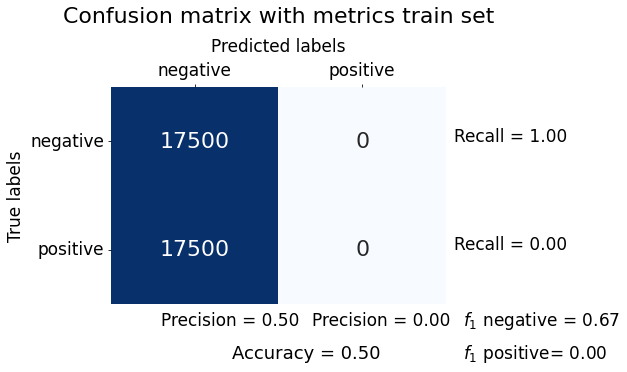

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


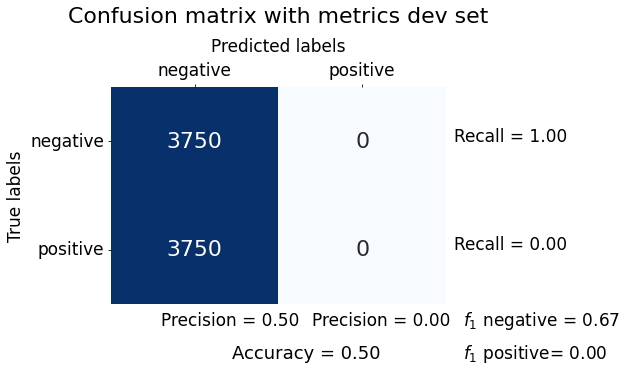

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


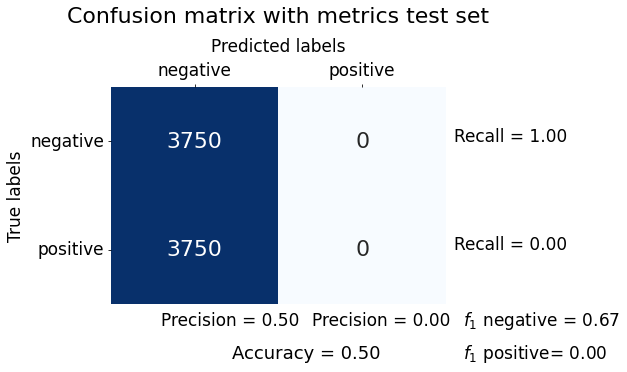

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

In [ ]:
plot_confusion_matrix(y_train, bestDummy.predict(x_train), title="Confusion matrix with metrics train set")
plot_confusion_matrix(y_dev, bestDummy.predict(x_dev), title="Confusion matrix with metrics dev set")
plot_confusion_matrix(y_test, bestDummy.predict(x_test), title="Confusion matrix with metrics test set")

Dummy Classification Report

In [ ]:
print("Classification Report for Train set\n")
print(classification_report(y_train, bestDummy.predict(x_train)))
print("Classification Report for Dev set\n")
print(classification_report(y_dev, bestDummy.predict(x_dev)))
print("Classification Report for Test set\n")
print(classification_report(y_test, bestDummy.predict(x_test)))

Classification Report for Train set



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.50      1.00      0.67     17500
           1       0.00      0.00      0.00     17500

    accuracy                           0.50     35000
   macro avg       0.25      0.50      0.33     35000
weighted avg       0.25      0.50      0.33     35000

Classification Report for Dev set



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.50      1.00      0.67      3750
           1       0.00      0.00      0.00      3750

    accuracy                           0.50      7500
   macro avg       0.25      0.50      0.33      7500
weighted avg       0.25      0.50      0.33      7500

Classification Report for Test set

              precision    recall  f1-score   support

           0       0.50      1.00      0.67      3750
           1       0.00      0.00      0.00      3750

    accuracy                           0.50      7500
   macro avg       0.25      0.50      0.33      7500
weighted avg       0.25      0.50      0.33      7500



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


***

## Naive Bayes

Grid search to find best Naive <br>*(commented out as we have the pretrained)*

In [ ]:
# parameters = {
#     'vect__max_features': [5000, 10000, 15000],
#     'vect__ngram_range': [(1, 2), (2,3)],
#     'clf__alpha': (1e-2, 1e-4, 1e-6)
# }

# clf_nb = MultinomialNB()

# bestNaive = grid_search_classify(clf_nb, parameters, x_train_total, y_train_total, cv=pds)
# bestNaive.fit(x_train, y_train)

Performing grid search for MultinomialNB()...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_features': [5000, 10000, 15000], 'vect__ngram_range': [(1, 2), (2, 3)], 'clf__alpha': (0.01, 0.0001, 1e-06)}
Fitting 1 folds for each of 18 candidates, totalling 18 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best score: 0.870
Best parameters set:
	clf__alpha: 0.01
	vect__max_features: 15000
	vect__ngram_range: (1, 2)


Pipeline(steps=[('vect',
                 TfidfVectorizer(max_features=15000, ngram_range=(1, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 sublinear_tf=True)),
                ('clf', MultinomialNB(alpha=0.01))])

Load (and dump) Best Naive Classifier  *( make sure the .pkl file is in the current dir )*

In [ ]:
# Commenting out the dump function for now - uncomment if you wish to dump a new trained model
# joblib.dump(bestNaive, 'naive_gridsearch.pkl')

['naive_gridsearch.pkl']

Load the pretrained model

In [ ]:
bestNaive = joblib.load(path + 'naive_gridsearch.pkl')
bestNaive

Pipeline(steps=[('vect',
                 TfidfVectorizer(max_features=15000, ngram_range=(1, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 sublinear_tf=True)),
                ('clf', MultinomialNB(alpha=0.01))])

Confusion matrix

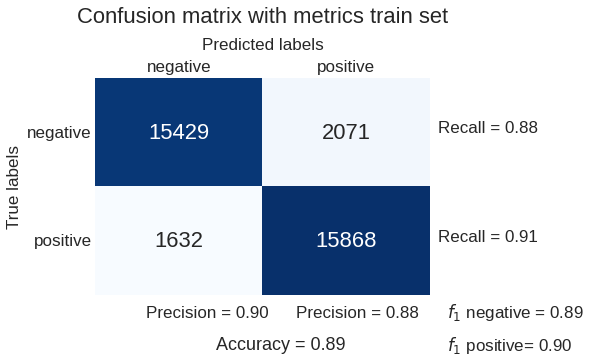

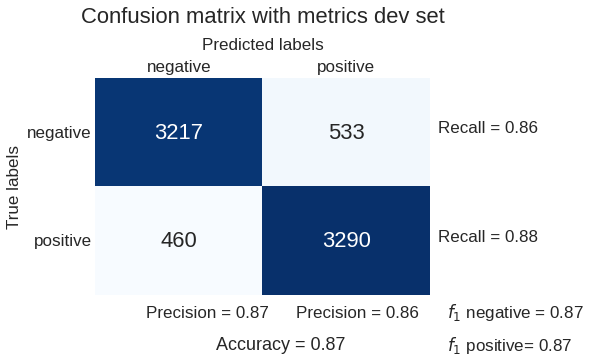

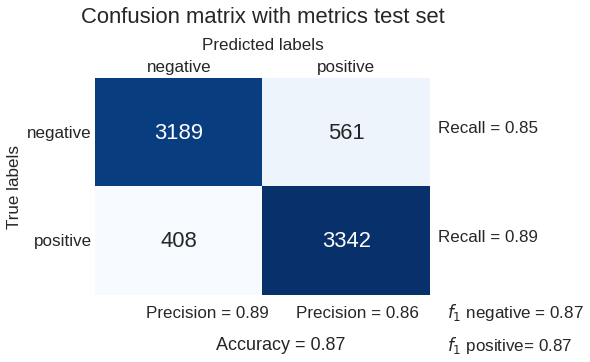

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

In [ ]:
plot_confusion_matrix(y_train, bestNaive.predict(x_train), title="Confusion matrix with metrics train set")
plot_confusion_matrix(y_dev, bestNaive.predict(x_dev), title="Confusion matrix with metrics dev set")
plot_confusion_matrix(y_test, bestNaive.predict(x_test), title="Confusion matrix with metrics test set")

Classification Report

In [ ]:
print("Classification Report for train set\n")
print(classification_report(y_train, bestNaive.predict(x_train)))
print("Classification Report for dev set\n")
print(classification_report(y_dev, bestNaive.predict(x_dev)))
print("Classification Report for test set\n")
print(classification_report(y_test, bestNaive.predict(x_test)))

Classification Report for train set

              precision    recall  f1-score   support

           0       0.90      0.88      0.89     17500
           1       0.88      0.91      0.89     17500

    accuracy                           0.89     35000
   macro avg       0.89      0.89      0.89     35000
weighted avg       0.89      0.89      0.89     35000

Classification Report for dev set

              precision    recall  f1-score   support

           0       0.90      0.87      0.88      3750
           1       0.88      0.90      0.89      3750

    accuracy                           0.89      7500
   macro avg       0.89      0.89      0.89      7500
weighted avg       0.89      0.89      0.89      7500

Classification Report for test set

              precision    recall  f1-score   support

           0       0.89      0.85      0.87      3750
           1       0.86      0.89      0.87      3750

    accuracy                           0.87      7500
   macro avg       0

****

## Logistic Regression

In [ ]:
# parameters = {
#     'vect__max_features': [5000, 10000, 15000],
#     'vect__ngram_range': [(1, 2), (2,3)],
#     'clf__solver': ['liblinear'],
#     'clf__C': [1, 10, 100, 1000]
# }

# clf_lr = LogisticRegression()

# bestLogistic = grid_search_classify(clf_lr, parameters, x_train_total, y_train_total, cv=pds)
# bestLogistic.fit(x_train, y_train)

Performing grid search for LogisticRegression()...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_features': [5000, 10000, 15000], 'vect__ngram_range': [(1, 2), (2, 3)], 'clf__solver': ['liblinear'], 'clf__C': [1, 10, 100, 1000]}
Fitting 1 folds for each of 24 candidates, totalling 24 fits
Best score: 0.894
Best parameters set:
	clf__C: 1
	clf__solver: 'liblinear'
	vect__max_features: 15000
	vect__ngram_range: (1, 2)


Pipeline(steps=[('vect',
                 TfidfVectorizer(max_features=15000, ngram_range=(1, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 sublinear_tf=True)),
                ('clf', LogisticRegression(C=1, solver='liblinear'))])

Save the trained model

In [ ]:
# Commenting out the dump function for now - uncomment if you wish to dump a new trained model

# joblib.dump(bestLogistic, 'logistic_gridsearch.pkl')

['logistic_gridsearch.pkl']

Load the pretrained Logistic regression model

In [ ]:
bestLogistic = joblib.load(path + 'logistic_gridsearch.pkl')
bestLogistic

Pipeline(steps=[('vect',
                 TfidfVectorizer(max_features=15000, ngram_range=(1, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 sublinear_tf=True)),
                ('clf', LogisticRegression(C=1, solver='liblinear'))])

Confusion matrix

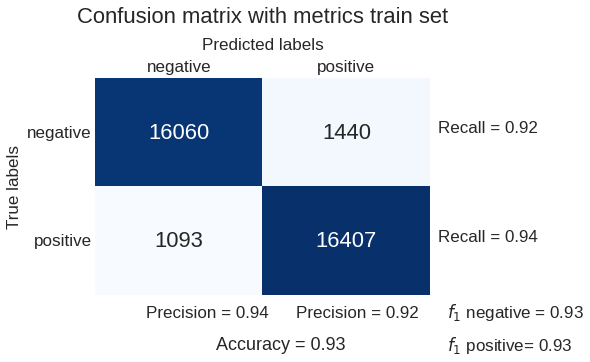

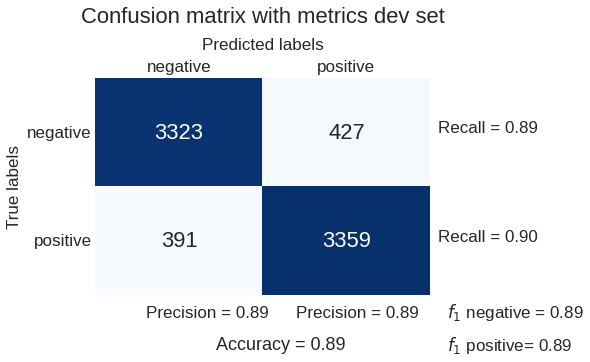

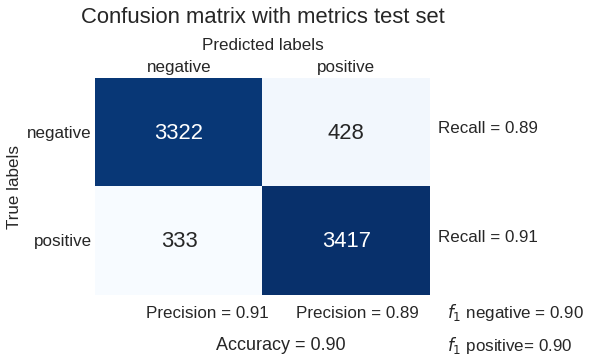

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

In [ ]:
plot_confusion_matrix(y_train, bestLogistic.predict(x_train), title="Confusion matrix with metrics train set")
plot_confusion_matrix(y_dev, bestLogistic.predict(x_dev), title="Confusion matrix with metrics dev set")
plot_confusion_matrix(y_test, bestLogistic.predict(x_test), title="Confusion matrix with metrics test set")

Classification reports

In [ ]:
print("Classification report for Logistic Regression for train set:")
print(classification_report(y_train, bestLogistic.predict(x_train)))
print("Classification report for Logistic Regression for dev set:")
print(classification_report(y_dev, bestLogistic.predict(x_dev)))
print("Classification report for Logistic Regression for test set:")
print(classification_report(y_test, bestLogistic.predict(x_test)))

Classification report for Logistic Regression for train set:
              precision    recall  f1-score   support

           0       0.94      0.93      0.93     17500
           1       0.93      0.94      0.93     17500

    accuracy                           0.93     35000
   macro avg       0.93      0.93      0.93     35000
weighted avg       0.93      0.93      0.93     35000

Classification report for Logistic Regression for dev set:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      3750
           1       0.92      0.93      0.93      3750

    accuracy                           0.93      7500
   macro avg       0.93      0.93      0.93      7500
weighted avg       0.93      0.93      0.93      7500

Classification report for Logistic Regression for test set:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      3750
           1       0.89      0.91      0.90      3750

  

Precision - Recall curves

****

## k-NN

(Commented out, if we change the model we will retrain it)

In [ ]:
# parameters = {
#     'vect__max_features': [5000, 10000, 15000],
#     'vect__ngram_range': [(1, 2), (2,3)],
#     'clf__n_neighbors': [2,5,10]
# }

# clf_knn = KNeighborsClassifier()

# bestKNN = grid_search_classify(clf_knn, parameters, x_train_total, y_train_total, cv=pds)
# bestKNN.fit(x_train, y_train)

Performing grid search for KNeighborsClassifier()...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_features': [5000, 10000, 15000], 'vect__ngram_range': [(1, 2), (2, 3)], 'clf__n_neighbors': [2, 5, 10]}
Fitting 1 folds for each of 18 candidates, totalling 18 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best score: 0.813
Best parameters set:
	clf__n_neighbors: 10
	vect__max_features: 15000
	vect__ngram_range: (1, 2)


Pipeline(steps=[('vect',
                 TfidfVectorizer(max_features=15000, ngram_range=(1, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 sublinear_tf=True)),
                ('clf', KNeighborsClassifier(n_neighbors=10))])

Save the trained model

In [ ]:
# Commenting out the dump function for now - uncomment if you wish to dump a new trained model

# joblib.dump(bestKNN, 'knn_gridsearch.pkl')

['knn_gridsearch.pkl']

Load the pretrained k-NN model

In [ ]:
bestKNN = joblib.load(path + 'knn_gridsearch.pkl')
bestKNN

Pipeline(steps=[('vect',
                 TfidfVectorizer(max_features=15000, ngram_range=(1, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 sublinear_tf=True)),
                ('clf', KNeighborsClassifier(n_neighbors=10))])

Confusion matrix

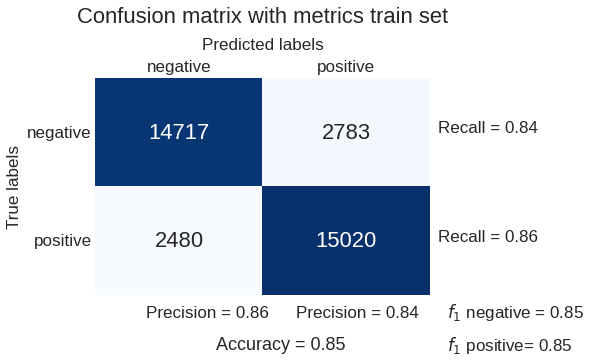

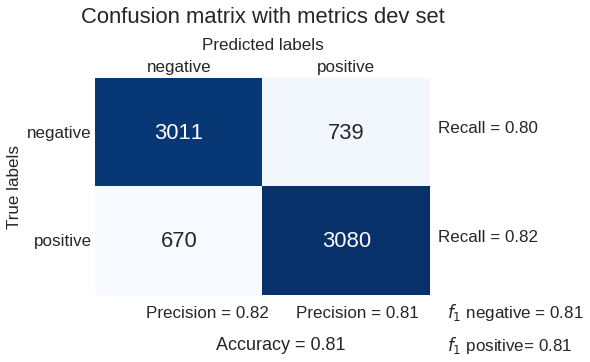

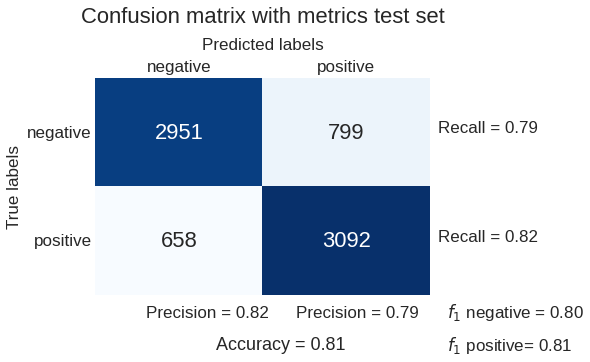

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

In [ ]:
plot_confusion_matrix(y_train, bestKNN.predict(x_train), title="Confusion matrix with metrics train set")
plot_confusion_matrix(y_dev, bestKNN.predict(x_dev), title="Confusion matrix with metrics dev set")
plot_confusion_matrix(y_test, bestKNN.predict(x_test), title="Confusion matrix with metrics test set")

Classification reports

In [ ]:
print("Classification report for k-NN classifier for train set:")
print(classification_report(y_train, bestKNN.predict(x_train)))
print("Classification report for kNN classifier for dev set:")
print(classification_report(y_dev, bestKNN.predict(x_dev)))
print("Classification report for kNN classifier for test set:")
print(classification_report(y_test, bestKNN.predict(x_test)))

Classification report for k-NN classifier for train set:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86     17500
           1       0.85      0.89      0.87     17500

    accuracy                           0.86     35000
   macro avg       0.86      0.86      0.86     35000
weighted avg       0.86      0.86      0.86     35000

Classification report for kNN classifier for dev set:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      3750
           1       0.85      0.88      0.87      3750

    accuracy                           0.86      7500
   macro avg       0.86      0.86      0.86      7500
weighted avg       0.86      0.86      0.86      7500

Classification report for kNN classifier for test set:
              precision    recall  f1-score   support

           0       0.84      0.78      0.81      3750
           1       0.80      0.85      0.82      3750

    accuracy    

Precision - Recall curves

***

## Precision - Recall Curves

for all classifiers, one for each class


In [ ]:
# a dictionary with the classifiers
classifiers = {
                "Dummy Classifier": bestDummy, 
                "Naive Bayes": bestNaive, 
                "Logistic Regression": bestLogistic,
                "kNN": bestKNN
               } 

# a dictionary with the subsets
subsets = {'Train': [x_train, y_train],
           'Development': [x_dev, y_dev],
           'Test': [x_test, y_test]}

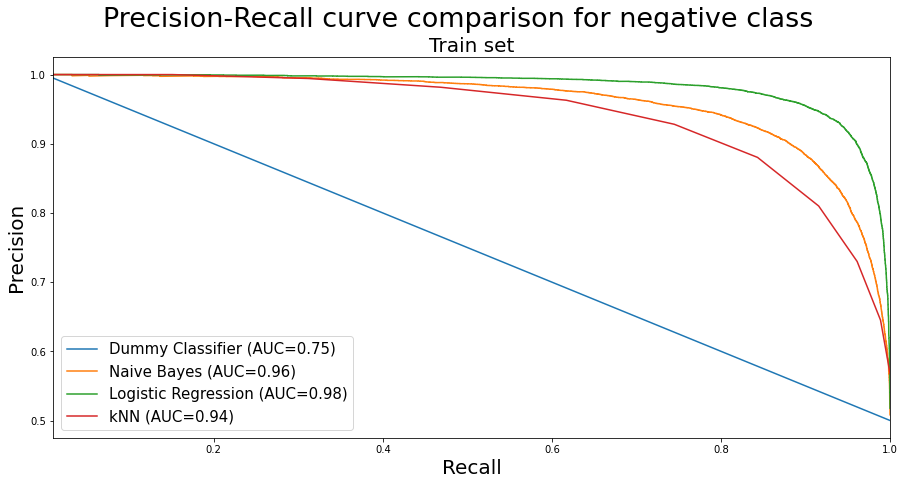

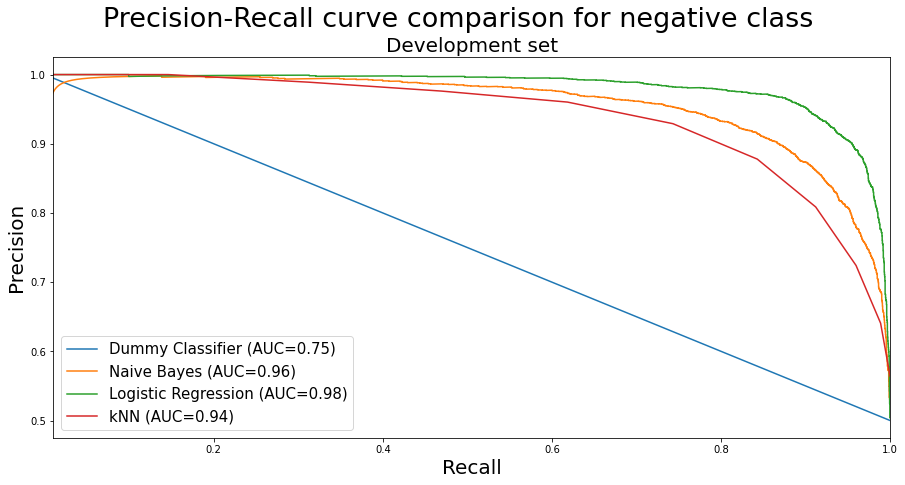

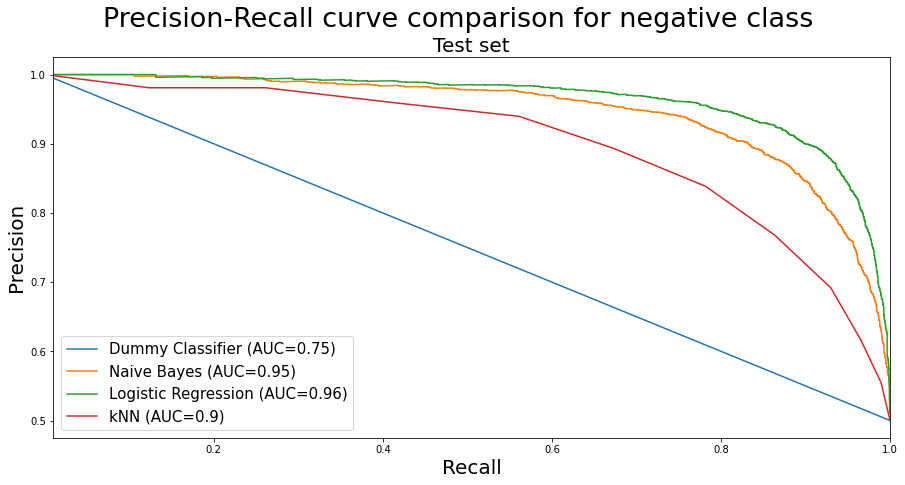

In [ ]:
plt.style.use('seaborn-whitegrid')
for subset_name, subset_list in subsets.items(): # iterate throughthe subsets

    plt.figure(figsize=(15,7))
    
    for name_clf, clf in classifiers.items(): # iterate through the classifiers

        # generate various of precision and recall scores with various thesholds
        precision, recall, threshlods = precision_recall_curve(1 - subset_list[1], clf.predict_proba(subset_list[0])[:,0])
        area = auc(recall,precision)
        plt.plot(recall, precision, label=name_clf + ' (AUC=' + str(round(area,2))+ ')')

    plt.title(subset_name + " set", fontsize=20)
    plt.suptitle("Precision-Recall curve comparison for negative class", fontsize=27)
    plt.xlabel("Recall", fontsize=20)
    plt.ylabel("Precision", fontsize=20)
    plt.legend(loc="lower left", fontsize=15)
    plt.xlim(0.01,1)
    plt.show()
    print()

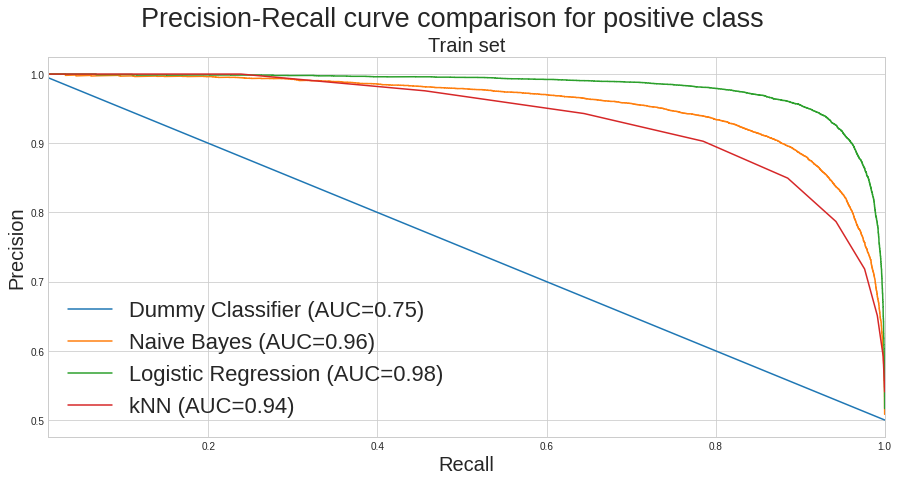

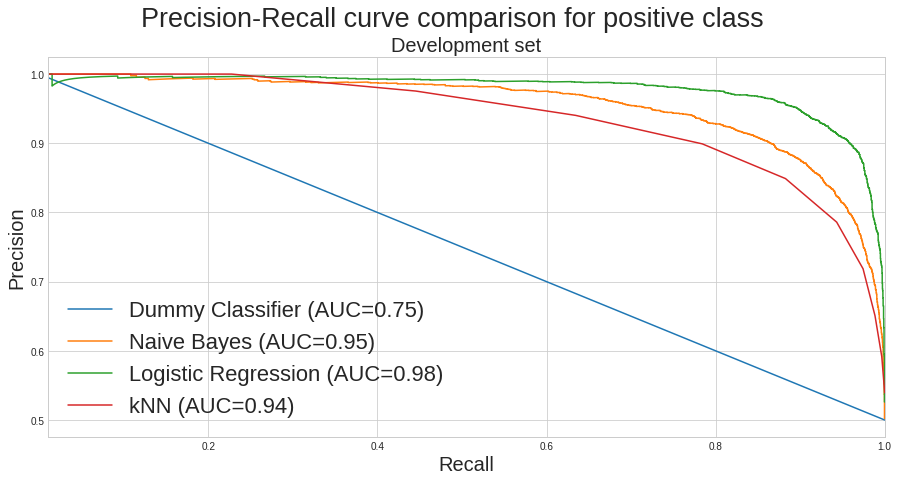

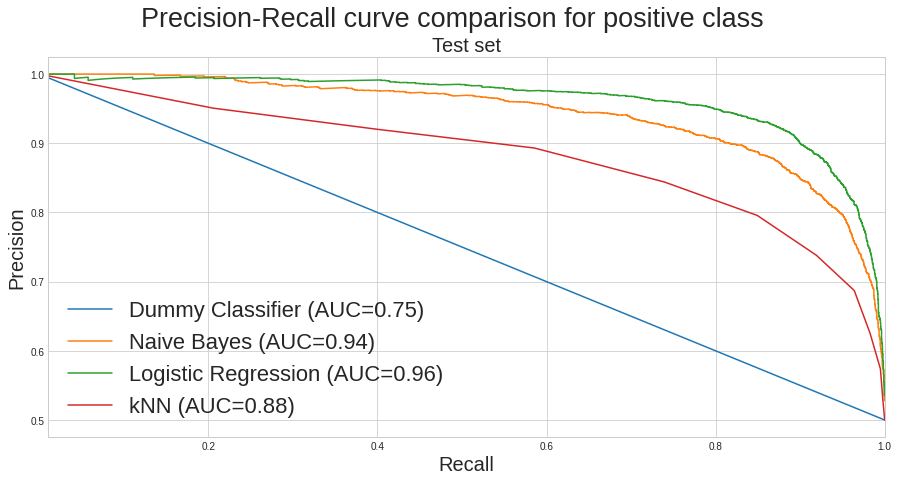

In [ ]:
plt.style.use('seaborn-whitegrid')
for subset_name, subset_list in subsets.items():

    plt.figure(figsize=(15,7))
    
    for name_clf, clf in classifiers.items():

        precision, recall, threshlods = precision_recall_curve(subset_list[1], clf.predict_proba(subset_list[0])[:,1])
        area = auc(recall,precision)
        plt.plot(recall, precision, label=name_clf + ' (AUC=' + str(round(area,2))+ ')')

    plt.title(subset_name + " set", fontsize=20)
    plt.suptitle("Precision-Recall curve comparison for positive class", fontsize=27)
    plt.xlabel("Recall", fontsize=20)
    plt.ylabel("Precision", fontsize=20)
    plt.legend(loc="lower left", fontsize=22)
    plt.xlim(0.01,1)
    plt.show()
    print()

***

## Learning Curves

one for each classifier

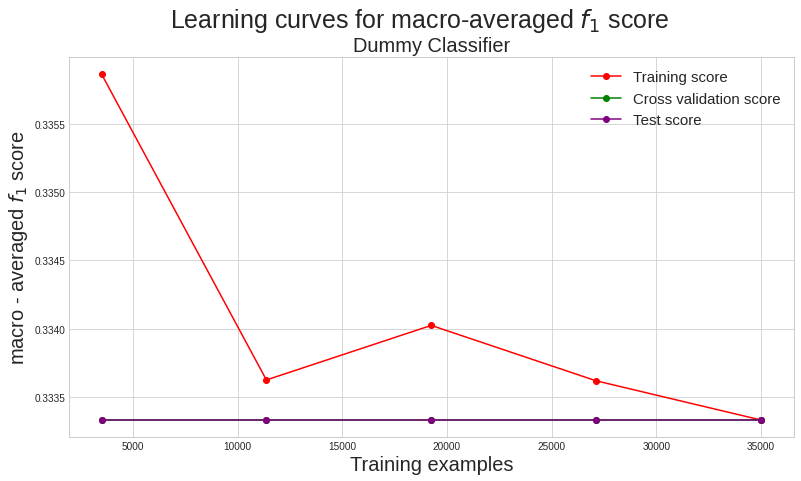

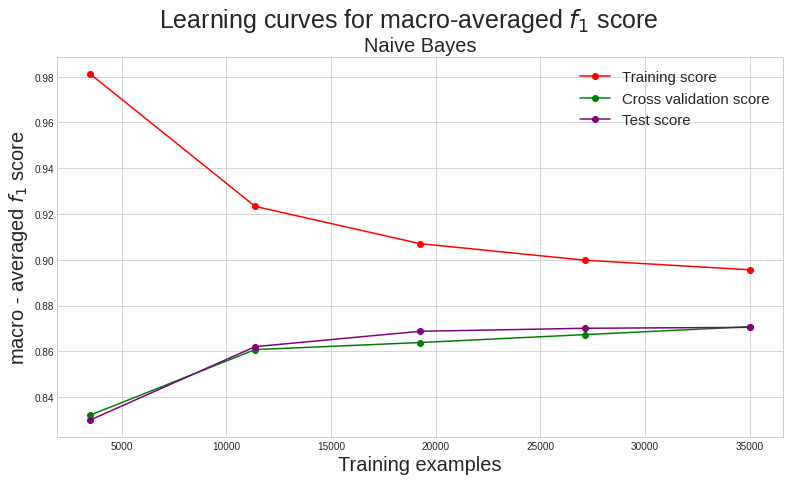

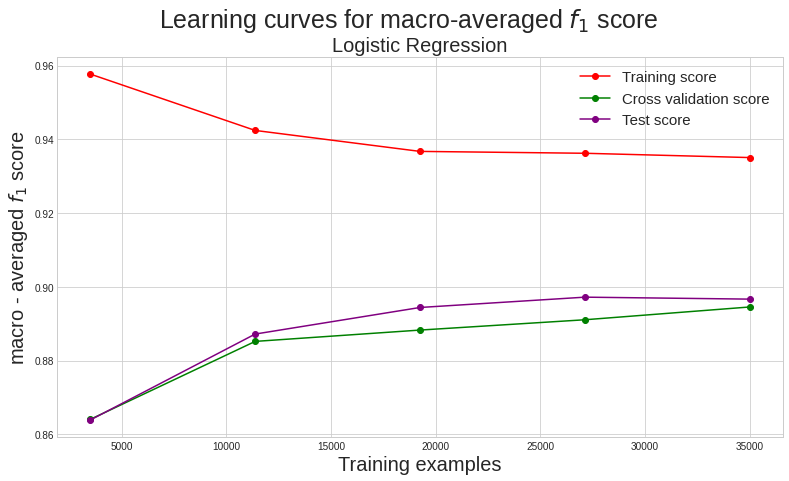

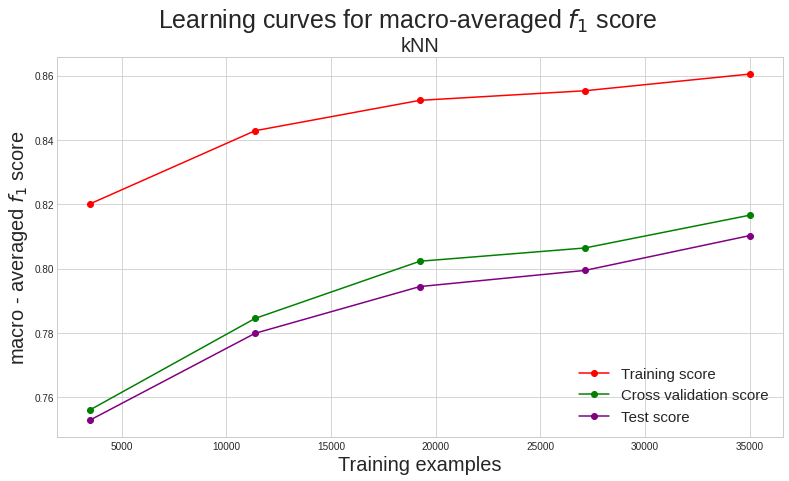

In [ ]:
plt.style.use('seaborn-whitegrid')
for name_clf, clf in list(classifiers.items()): # iterate through the classfiers

    # fit the vectorizer first
    vectorized_x_train = clf[0].fit_transform(x_train_total)
    # generate the train and test scores for the learning curves for various train sizes
    train_sizes, train_scores, test_scores = learning_curve(
        clf[1],
        vectorized_x_train,
        y_train_total,
        cv=pds,
        train_sizes=np.linspace(0.1, 1.0, 5),
        scoring='f1_macro'
    )

    train_scores_mean = np.mean(train_scores, axis=1) # take the mean of the train scores from cv
    test_scores_mean = np.mean(test_scores, axis=1) # take the mean of the test scores from cv

    plt.figure(figsize=(13,7))

    # plot the train and dev learning curves
    plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross validation score")
    
    #plot test curve as well
    vectorized_x_test = clf[0].transform(x_test)
    glist=[]
    for i in range(len(list(train_sizes))):
      tr = list(train_sizes)[i]
      # fit the model 
      clf[1].fit(vectorized_x_train[:tr], y_train_total.iloc[:tr])
      # test prediction
      y = clf[1].predict(vectorized_x_test)
      #y = np.mean(y, axis=1)
      g = f1_score(y_test, y, average='macro')
      glist.append(g)
    plt.plot(list(train_sizes),glist, "o-", color="purple", label="Test score")
    

    plt.title(name_clf, fontsize=20)
    plt.suptitle("Learning curves for macro-averaged $f_1$ score", fontsize=25)
    plt.xlabel("Training examples", fontsize=20)
    plt.ylabel("macro - averaged $f_1$ score", fontsize=20)
    plt.legend(fontsize=15)
   

    plt.show()
    print()

## Dimensionality Reduction with SVD

Using SVD to fit again the models in a lower dimension and see if there is a significant change on their performance

In [ ]:
tf_idf_vectorizer = TfidfVectorizer(
        ngram_range = (1, 2),
        max_features = 15000,
        sublinear_tf = True,
        lowercase = True,
        stop_words = stopwords.words('english')
    )

vectorized_x_train = tf_idf_vectorizer.fit_transform(x_train)
vectorized_x_dev = tf_idf_vectorizer.transform(x_dev)
vectorized_x_test = tf_idf_vectorizer.transform(x_test)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


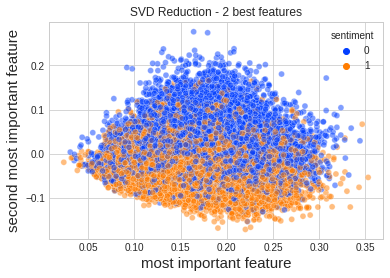

In [ ]:
# Dimensionality Reduction using SVD
svd = TruncatedSVD(n_components=2, random_state=1994)
palette = sns.color_palette("bright", 2)

x_train_trunc = svd.fit_transform(vectorized_x_train)

plt.figure()
plt.title('SVD Reduction - 2 best features')
sns.scatterplot(x_train_trunc[:,0], x_train_trunc[:,1], hue=y_train, legend='full', palette=palette, alpha=0.5)
plt.xlabel("most important feature", fontsize=15)
plt.ylabel("second most important feature", fontsize=15)
plt.show()

### Dimensionality reduction for logistic regression

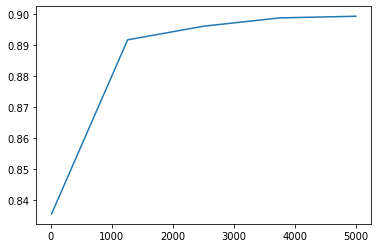

In [ ]:
comp = np.linspace(10, 5000, 5)

f1 = []

for c in comp:
  svd = TruncatedSVD(n_components = int(c), random_state = 1994)

  x_train_svd = svd.fit_transform(vectorized_x_train)
  x_dev_svd = svd.transform(vectorized_x_dev)
  x_test_svd = svd.transform(vectorized_x_test)

  bestLogistic[1].fit(x_train_svd, y_train)

  f1.append(f1_score(y_test, bestLogistic[1].predict(x_test_svd), average='macro'))

# plt.plot(comp, f1)

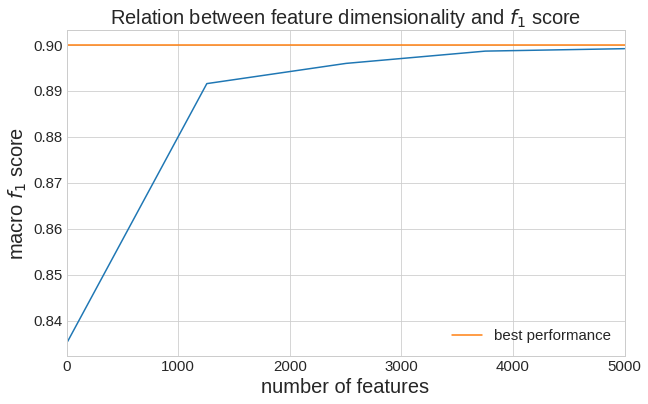

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.style.use("seaborn-whitegrid")
plt.plot(comp, f1)
plt.plot(comp, len(comp)*[0.9], label="best performance")
plt.title("Relation between feature dimensionality and $f_1$ score", fontsize = 20)
plt.xlabel("number of features", fontsize=20)
plt.ylabel("macro $f_1$ score", fontsize=20)
plt.xlim(0,5000)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()

In [ ]:
svd = TruncatedSVD(n_components = 50, random_state = 1994)

In [ ]:
x_train_svd = svd.fit_transform(vectorized_x_train)
x_dev_svd = svd.transform(vectorized_x_dev)
x_test_svd = svd.transform(vectorized_x_test)

In [ ]:
# bestNaive[1].fit(x_train_svd, y_train)
# print(classification_report(y_test, bestNaive[1].predict(vectorized_x_test)))

MultinomialNB can't word work with negative values
https://stackoverflow.com/a/34907803

#### Logistic regression with svd

In [ ]:
bestLogistic[1].fit(x_train_svd, y_train)
print(classification_report(y_test, bestLogistic[1].predict(x_test_svd)))

              precision    recall  f1-score   support

           0       0.89      0.88      0.89      3750
           1       0.88      0.90      0.89      3750

    accuracy                           0.89      7500
   macro avg       0.89      0.89      0.89      7500
weighted avg       0.89      0.89      0.89      7500



#### svm with svd

In [ ]:
clf_svm = svm.SVC(kernel = 'rbf')
clf_svm.fit(x_train_svd, y_train)
print(classification_report(y_test, clf_svm.predict(x_test_svd)))

              precision    recall  f1-score   support

           0       0.87      0.86      0.87      3750
           1       0.87      0.87      0.87      3750

    accuracy                           0.87      7500
   macro avg       0.87      0.87      0.87      7500
weighted avg       0.87      0.87      0.87      7500



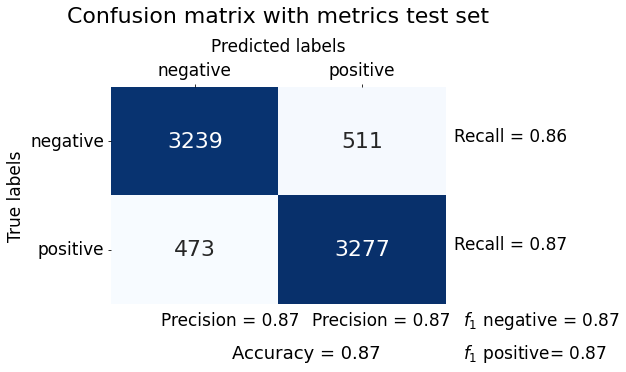

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

In [ ]:
plot_confusion_matrix(y_test, clf_svm.predict(x_test_svd), title="Confusion matrix with metrics test set")